## Numba - GPU kernel programming
#### Open type-specializing, function compiler for accelerating numerical computation in Python

* #### provides function compilation tools for both CPU and GPU targets 
    * compiles Python functions
    * Python module
* #### type-specializing
    * speeds up your function by generating a specialized implementation for the specific data types 
    * Python functions are designed to operate on generic data types - very flexible but also very slow
* #### just-in-time
    * Numba translates functions when they are first called
    * compiler knows what argument types we will be using
* #### numerical computation
    * focused on numerical data types, like int, float, and complex
    * very limited string processing support

* #### compile Python functions for execution on the CPU
* #### includes Python-native API for programming NVIDIA GPUs through the CUDA driver 
* #### provide built-in support for sending NumPy arrays to the GPU and accessing them with Python syntax

#### Numba Manual: http://numba.pydata.org/numba-doc/latest/cuda/cudapysupported.html


### Numba for GPU
Numba supports CUDA GPU programming by directly compiling a restricted subset of Python code into CUDA kernels and device functions following the CUDA execution model. Kernels written in Numba appear to have direct access to NumPy arrays. NumPy arrays are transferred between the CPU and the GPU automatically.

### Installation
* you need both numba and cudatoolkit to enable Numba's GPU support
* `conda install numba cudatoolkit`

### What is happening behind the scene
![](graphics/numba.png)

### First numba function

#### Problem
Calculating the length of the hypotenuse of a triangle is possible using the square root function on the sum of two squares, but hypot(x, y) avoids problems that occur when squaring very large or very small numbers.

#### Solution
https://en.wikipedia.org/wiki/Hypot


In [1]:
# Numba compiler is typically enabled by applying a decorator to a Python function
# Decorators are functions that transform Python functions.
# CPU compilation decorator

from numba import jit
import math

@jit
def hypot(x, y):
    # Implementation from https://en.wikipedia.org/wiki/Hypot
    x = abs(x);
    y = abs(y);
    t = min(x, y);
    x = max(x, y);
    t = t / x;
    return x * math.sqrt(1+t*t)

In [2]:
# Equivalent code:
def hypot(x, y):
    x = abs(x);
    y = abs(y);
    t = min(x, y);
    x = max(x, y);
    t = t / x;
    return x * math.sqrt(1+t*t)

hypot = jit(hypot)

In [3]:
# Call the function and get an output
# First time call triggers the compiler and compiles
# a machine code implementation for float inputs
hypot(3.0,4.0)

5.0

In [4]:
# Numba saves also the original Python implementation
# This calls original Python code
hypot.py_func(3.0,4.0)

5.0

#### Type inference

In [1]:
!nvidia-smi

Thu Nov 10 09:24:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA Quadro R...  On   | 00000000:00:05.0  On |                  N/A |
| 30%   36C    P8     7W / 125W |    326MiB /  7982MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
import numba
from numba import cuda

In [6]:
print(numba.cuda.gpus)

<Managed Device 0>


In [7]:
numba.cuda.select_device(0)

<weakproxy at 0x7f74e1b8ec20 to Device at 0x7f74e3608670>

In [ ]:
#first program

In [8]:
data=range(10)

def test(i):
    return i

[test(i)  for i in data]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [10]:
data=range(10)
output=[]

def test(i):
    output.append(i)
[test(i) for i in data]

output

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [11]:
import numpy as np
data=np.asarray(range(10))
output=np.zeros(len(data))

def test(i):
    output[i]=i
    
[test(i) for i in data]
output




array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [13]:
data=np.asarray(range(10))
output=np.zeros(len(data))

@cuda.jit
def test(input_array,output_array):
    i=cuda.grid(1)
    output_array[i]=i
    
#test[blocks, threads](input,output)
test[1,len(data)](data,output)

output

/home/paperspace/anaconda3/envs/rapids/lib/python3.9/site-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/paperspace/anaconda3/envs/rapids/lib/python3.9/site-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [14]:
random_array=np.random.random(10_000_000)

In [15]:
random_array

array([0.99411194, 0.95018006, 0.64027243, ..., 0.16617518, 0.65211285,
       0.98172884])

In [16]:
output=np.zeros_like(random_array)
output

array([0., 0., 0., ..., 0., 0., 0.])

In [18]:
%%time
def test(i):
    output[i]=random_array[i]*2
    
[test(i) for i in range(len(random_array))]
output

CPU times: user 2.68 s, sys: 0 ns, total: 2.68 s
Wall time: 2.68 s


array([1.98822387, 1.90036012, 1.28054486, ..., 0.33235037, 1.3042257 ,
       1.96345768])

In [ ]:
for i in random_array:
    i=i*2


In [21]:
import math

In [ ]:
%%time
def test(i):
    output[i]=random_array[i]*2
    
[test(i) for i in range(len(random_array))]
output

In [22]:
output=np.zeros_like(random_array)
threads=128
blocks=math.ceil(random_array.shape[0]/128)

In [23]:
blocks

78125

In [25]:
%%time
output=np.zeros_like(random_array)
threads=128
blocks=math.ceil(random_array.shape[0]/128)

@cuda.jit
def test(input_array,output_array):
    i=cuda.grid(1)
    output_array[i]=input_array[i]*2
    
    
test[blocks,threads](random_array,output)
output

CPU times: user 186 ms, sys: 27.4 ms, total: 214 ms
Wall time: 216 ms


/home/paperspace/anaconda3/envs/rapids/lib/python3.9/site-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


array([1.98822387, 1.90036012, 1.28054486, ..., 0.33235037, 1.3042257 ,
       1.96345768])

In [26]:
%%time
random_array*2

CPU times: user 13.7 ms, sys: 23.6 ms, total: 37.3 ms
Wall time: 36 ms


array([1.98822387, 1.90036012, 1.28054486, ..., 0.33235037, 1.3042257 ,
       1.96345768])

In [27]:
gpu_random_array=cuda.to_device(random_array)
gpu_output=cuda.to_device(np.zeros_like(random_array))

In [28]:
gpu_random_array

In [30]:
%%time
test[blocks,threads](gpu_random_array,gpu_output)

CPU times: user 0 ns, sys: 12.3 ms, total: 12.3 ms
Wall time: 13.6 ms


In [32]:
output_from_array=gpu_output.copy_to_host()

In [33]:
output_from_array

array([1.98822387, 1.90036012, 1.28054486, ..., 0.33235037, 1.3042257 ,
       1.96345768])

In [34]:
@cuda.jit
def add_kernel(x,y,out):
    
    tx=cuda.threadIdx.x
    ty=cuda.blockIdx.x
    
    block_size=cuda.blockDim.x
    grid_size=cuda.gridDim.x
    
    start=tx+ty*block_size
    stride=block_size*grid_size
    
    for i in range(start,x.shape[0], stride):
        out[i]=x[i]+y[i]
    
    

In [39]:
n=1_000_000
x=np.arange(n)
y=2*x
out=np.empty_like(x)

threads_per_block=128
blocks_per_grid=30


In [41]:
add_kernel[blocks_per_grid,threads_per_block](x,y,out)
out[:30]

/home/paperspace/anaconda3/envs/rapids/lib/python3.9/site-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 30 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/paperspace/anaconda3/envs/rapids/lib/python3.9/site-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


array([ 0,  3,  6,  9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48,
       51, 54, 57, 60, 63, 66, 69, 72, 75, 78, 81, 84, 87])

In [42]:
@cuda.jit

def add_kernel(x,y,out):
    start=cuda.grid(1)
    
    stride=cuda.gridsize(1)
    
    
    for i in range(start, x.shape[0], stride):
        out[i]=x[i]+y[i]

In [46]:
add_kernel[blocks_per_grid,threads_per_block](x,y,out)
out[:30]

/home/paperspace/anaconda3/envs/rapids/lib/python3.9/site-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 30 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/paperspace/anaconda3/envs/rapids/lib/python3.9/site-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


array([ 0,  3,  6,  9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48,
       51, 54, 57, 60, 63, 66, 69, 72, 75, 78, 81, 84, 87])

In [49]:
#CPU input/output array no synch
cuda.synchronize()

%timeit add_kernel[blocks_per_grid,threads_per_block](x,y,out)

cuda.synchronize()

13.1 ms ± 157 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [48]:
#CPU input/output array explicit synch
cuda.synchronize()
%timeit add_kernel[blocks_per_grid,threads_per_block](x,y,out); cuda.synchronize()

12.9 ms ± 200 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [50]:
x_device=cuda.to_device(x)
y_device=cuda.to_device(y)
out=cuda.device_array_like(x)

In [51]:
#GPU i/o array no synch
cuda.synchronize()
%timeit add_kernel[blocks_per_grid,threads_per_block](x,y,out)
cuda.synchronize()

8.62 ms ± 224 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [52]:
#GPU explicit synch
cuda.synchronize()
%timeit add_kernel[blocks_per_grid,threads_per_block](x,y,out);cuda.synchronize()

8.51 ms ± 222 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
#monte carlo simpulation

In [53]:
from numba.cuda.random import create_xoroshiro128p_states, xoroshiro128p_uniform_float32

In [62]:
threads_per_block=64
blocks=24
rng_states=create_xoroshiro128p_states(threads_per_block*blocks,seed=1)
iterations=10_000

In [63]:
@cuda.jit

def compute_pi(rng_states,iterations,out):
    
    thread_id=cuda.grid(1)
    inside=0
    for i in range(iterations):
        x=xoroshiro128p_uniform_float32(rng_states,thread_id)
        y=xoroshiro128p_uniform_float32(rng_states,thread_id)
        if x**2+y**2<=1.0:
            inside+=1
    out[thread_id]=4.0*inside/iterations
    


In [64]:
out=np.zeros(threads_per_block*blocks)
compute_pi[blocks,threads_per_block](rng_states,iterations,out)

/home/paperspace/anaconda3/envs/rapids/lib/python3.9/site-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


In [65]:
out.mean()

3.1416734375

In [68]:
a=np.array([1,2,3,4])
b=np.array([2,3,4,5])

In [71]:
from numba import vectorize
@vectorize(['int64(int64,int64)'], target='cuda')
def add_unfunc(x,y):
    return x+y

add_unfunc(a,b)
    
    

/home/paperspace/anaconda3/envs/rapids/lib/python3.9/site-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


array([3, 5, 7, 9])

In [ ]:
c=np.array()

In [72]:
a.dtype

dtype('int64')

In [85]:
%timeit np.add(a,b)

477 ns ± 10.6 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [84]:
b_gpu=cuda.to_device(b)
c_gpu=cuda.to_device(c)

%timeit add_unfunc(b_gpu,c_gpu)

array([[16]])

In [86]:
x=np.random.uniform(-3,3,size=10_000_000)
mean=np.float64(0)
sigma=np.float64(1)



In [87]:
from scipy.stats import norm
%timeit norm.pdf(x,mean,sigma)

610 ms ± 16.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


sqrt_2pi=2*math.pi)

In [88]:
sqrt_2pi=(2*math.pi)**.5

In [89]:
vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv

In [90]:
gaussian_pdf(x[0],0.0,1.0)

/home/paperspace/anaconda3/envs/rapids/lib/python3.9/site-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


array([0.39605608])

In [91]:
%timeit gaussian_pdf(x,mean,sigma)

90.7 ms ± 3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
def compute_pi():
    
    

In [17]:
[i*2 for i in random_array]

[1.9882238740948681,
 1.900360117386707,
 1.2805448592702309,
 1.3844850909587763,
 0.2720513966987006,
 0.2949494385599205,
 1.1884898114362292,
 0.007286315444605895,
 1.847533119225975,
 1.549927896930004,
 1.0454865564205291,
 1.3044605140240475,
 0.0851550712017426,
 0.07044421143037094,
 1.7461215556882523,
 0.13231918216630212,
 1.247183212392706,
 1.2082084352325724,
 1.9561926014754394,
 0.3500645791888577,
 0.8159292052560516,
 0.16642130201444294,
 0.8990256696238219,
 1.6786661863763659,
 0.8982037622224195,
 1.9160896886802807,
 0.770301509177362,
 0.6072831516071495,
 1.053476428998695,
 1.4979936358321282,
 1.8718067349407161,
 1.6933412406631376,
 0.23471463768022627,
 1.8512085537187208,
 0.5333798375977641,
 0.05761294791266858,
 1.6923021829805132,
 1.5916360333000266,
 0.9600201797493895,
 1.578397219218244,
 1.9147931910499603,
 1.457656934881305,
 0.4597060973853886,
 0.35474577169261035,
 1.1761002384646233,
 0.8323630751714555,
 0.25224981240169764,
 1.482957331

In [8]:
hypot.inspect_types()

hypot (float64, float64)
--------------------------------------------------------------------------------
# File: <ipython-input-2-cb2130edd906>
# --- LINE 2 --- 
# label 0

def hypot(x, y):

    # --- LINE 3 --- 
    #   x = arg(0, name=x)  :: float64
    #   y = arg(1, name=y)  :: float64
    #   $0.1 = global(abs: <built-in function abs>)  :: Function(<built-in function abs>)
    #   $0.3 = call $0.1(x, func=$0.1, args=[Var(x, <ipython-input-2-cb2130edd906> (3))], kws=(), vararg=None)  :: (float64,) -> float64
    #   del x
    #   del $0.1
    #   x.1 = $0.3  :: float64
    #   del $0.3

    x = abs(x);

    # --- LINE 4 --- 
    #   $0.4 = global(abs: <built-in function abs>)  :: Function(<built-in function abs>)
    #   $0.6 = call $0.4(y, func=$0.4, args=[Var(y, <ipython-input-2-cb2130edd906> (3))], kws=(), vararg=None)  :: (float64,) -> float64
    #   del y
    #   del $0.4
    #   y.1 = $0.6  :: float64
    #   del $0.6

    y = abs(y);

    # --- LINE 5 --- 
    #   $0.7 = g

#### Benchmark
* Python's built-in may be even faster than Numba This is because Numba does introduce some overhead to each function call that is larger than the function call overhead of Python itself

In [6]:
# Python
%timeit hypot.py_func(3.0, 4.0)

607 ns ± 14.9 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [7]:
# Numba
%timeit hypot(3.0, 4.0)

138 ns ± 2.21 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


### Not all Python code an be compiled
* some functions don't have a Numba-translation
* some kinds of Python types can't be efficiently compiled at all
* Numba does not support dictionaries

-----

## GPU programming in Numba


### Several important terms in the topic of CUDA programming are listed here:

- host
    - the CPU
- device
    - the GPU
- host memory
    - the system main memory
- device memory
    - onboard memory on a GPU card
- kernel
    - a GPU function launched by the host and executed on the device
- device function
    - a GPU function executed on the device which can only be called from the device (i.e. from a kernel or another device function)

## What is a kernel?

A kernel is similar to a function, it is a block of code which takes some inputs and is executed by a processor.

The difference between a function and a kernel is:
- A kernel cannot return anything, it must instead modify memory
- A kernel must specify its thread hierarchy (threads and blocks)

## Recap on  grids, threads and blocks (and warps)?


<figure>

![CPU GPU Comparison](graphics/threads-blocks-warps.png)

<figcaption style="text-align: center;"> 
    
Image source <a href="https://docs.nvidia.com/cuda/cuda-c-programming-guide/">https://docs.nvidia.com/cuda/cuda-c-programming-guide/</a>
    
</figcaption>
</figure>


Rules of thumb for threads per block:
- Should be a round multiple of the warp size (32)
- A good place to start is 128-512 but benchmarking is required to determine the optimal value.


## Two aproaches of GPU programming in Numba:
* CUDA Python kernels
* ufuncs/gufuncs


* Maximum throughput is achieved in the scenario of computing the same operations on many different elements at once

## CUDA kernel
* ufuncs are the easiest way in Numba to use the GPU
* CUDA kernel provides greater flexibility as it is required in many problems

#### Creating Cuda kernel

![](graphics/cuda_kernel.png)



#### Deciding on the size of a block and grid
 

## First program 

## Let's get bigger

Now that we've run our first CUDA kernel with Numba let's try something a little bigger.

This time we are going to take a large array and double every number in it. We will do it first in pure Python on the CPU and then in a CUDA kernel on the GPU.


## Memory management

Earlier we discussed that the CPU and GPU are effectively two separate computers. Each of these computers has it's own memory. 

All of the data we've worked with so far has been created with numpy on the CPU. So in order for `numba` to work with this data on the GPU it has been quietly copying data back and forth for us.




### Creating a function - recap
* The pattern of computing a starting index and a stride is a common way to ensure that
your grid size is independent of the input size
* The striding will maximize bandwidth by ensuring that threads with consecuitive 
#indices are accessing consecutive memory locations
* no need to specify a type signature for the CUDA kernel
* Numba can infer the type signature from the inputs automatically

### Calling a function
* syntax for calling the kernel function mimic CUDA Runtime API in C
* args in square brackets define the size and shape of the thread grid
* args with parentheses correspond to the kernel function arguments
* the arguments are passed to the kernel as full NumPy arrays
* kernel can access any element in the array it wants regardless of its position in the thread grid
* This is more powerful than ufuncs


#### Simplification with helper functions
* NumPy arrays forces Numba to allocate GPU memory
* copy the arguments to the GPU
* run the kernel
* copy the argument arrays back to the host

This not very efficient, so you will often want to allocate device arrays:


#### Kernel Synchronization


#### Random numbers
* useful in Monte Carlo simulations
* numba implemented xoroshiro128+ generator

In [7]:
# Initialize the RNG state on the host for each thread in kernel
# state creation function initializes each state to be in the same
# sequence designated by the seed, but separated by $2^{64}$ steps from each other.

import numpy as np
from numba import cuda
from numba.cuda.random import create_xoroshiro128p_states, xoroshiro128p_uniform_float32

threads_per_block = 64
blocks = 24
rng_states = create_xoroshiro128p_states(threads_per_block * blocks, seed=1)


#### Exercise
* create a function to compute pie 


#### ufuncs - Universal functions
* functions that can take NumPy arrays of varying dimensions (or scalars) and operate on them element-by-element
* naturally data parallel
* More on ufuncs in Numpy https://docs.scipy.org/doc/numpy/reference/ufuncs.html

In [3]:
# Numpy example of ufuncs
import numpy as np

a = np.array([1, 2, 3, 4])
b = np.array([10, 20, 30, 40])

np.add(a, b)

array([11, 22, 33, 44])

In [4]:
# Arrays of different, but compatible dimensions can also be combined
# The lower dimensional array will be replicated to match the dimensionality of the higher dimensional array
c = np.arange(4*4).reshape((4,4))
print('c:', c)

np.add(b, c)

c: [[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]


array([[10, 21, 32, 43],
       [14, 25, 36, 47],
       [18, 29, 40, 51],
       [22, 33, 44, 55]])

In [5]:
b_col = b[:, np.newaxis]
b_col


np.add(b_col, c)

array([[10, 11, 12, 13],
       [24, 25, 26, 27],
       [38, 39, 40, 41],
       [52, 53, 54, 55]])

#### ufuncs for GPU
* Numba create compiled ufuncs
* we provide a scalar function of all the inputs, and Numba will figure out the broadcast rules 
* ufunc on CUDA requires giving an explicit type signature and setting the target attribute



#### What happened?


#### GPU slower than CPU????
* inputs are to small - GPU achieves performance through parallelism and we need a much larger array
* calculation is too simple - overhead cost of sending calculation to GPU 
* copy the data to and from the GPU
* data types larger than necessary - 32/64 bit run the same speed on CPU but 64bit have a significant performance cost on the GPU

#### Cuda device functions
* Device functions are created with the numba.cuda.jit decorator
* CUDA compiler aggressively inlines device functions, so there is generally no overhead for function calls
* function below returns tuple that is not actually created as a Python object
* output is temporarily represented as a struct, which is then optimized away by the compiler

#### Python code on the GPU
* #### if/elif/else
* #### while and for loops
* #### basic math operators
* #### some functions from the math and cmath modules
* #### tuples

#### Exercise
Eliminate low amplitude noise by forcing all sample values below a certain absolute magnituder to be zero

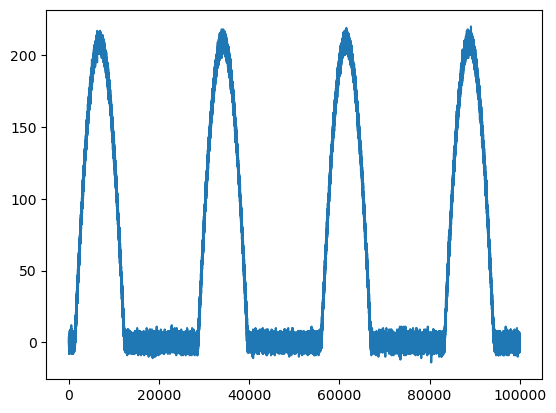

In [97]:
# Hacking up a noisy pulse train
%matplotlib inline
from matplotlib import pyplot as plt

n = 100000
noise = np.random.normal(size=n) * 3
pulses = np.maximum(np.sin(np.arange(n) / (n / 23)) - 0.3, 0.0)
waveform = ((pulses * 300) + noise).astype(np.int16)
plt.plot(waveform)

In [98]:
@vectorize (['int16(int16,int16)'],target='cuda')
def dump(wave_value,cutoff):
        if abs(wave_value)>=cutoff:
            return wave_value
        else:
            return cutoff
        


In [99]:
waveform

array([ 0,  2,  0, ..., -1,  0,  1], dtype=int16)

/home/paperspace/anaconda3/envs/rapids/lib/python3.9/site-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 98 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


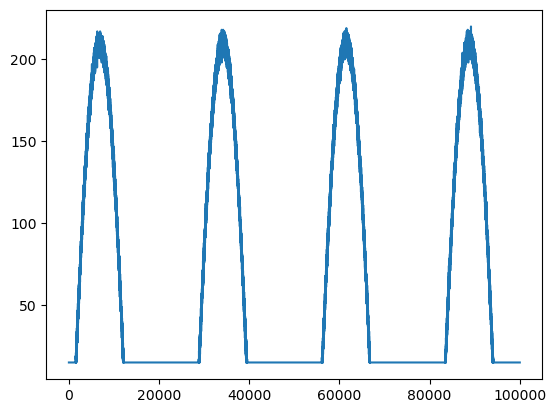

In [101]:
plt.plot(dump(waveform,15.0))

### Utilising GPU Memory
* reduce the impacy of host-to-device/device to host bandwidth
* best to copy data to the GPU explicitly if wanted to use over multiple function calls
* allocating device memory can be relatively slow
* allocate GPU arrays and the provide data from the host to improveme performance further


#### Copying host data to the GPU
* return CUDA device array with data in GPU memory
* device arrays can be passed to CUDA functions just like NumPy array

In [102]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()

In [ ]:
aaaaaaaaaaaaaaaaaa